## Goal: timeseries plots of DJF-mean SST and Chl
___
#### Secondary Goal: how does each step in your workflow result in a dimension reduction?

In [1]:
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr
import pandas as pd

#### Read in an ensemble member from the CESM-LE

In [2]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl', 'spChl', 'diazChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
        
        
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

variables = list(filter(lambda v: 'Chl' not in v, variables)) + ['Chl_surf']
ds = ds[variables+grid_vars]
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1872, 2), meta=np.ndarray>

### Reduce data set to a date range:

In [3]:
## Clip to 1920 - end:
ds_rec = ds[variables+grid_vars].isel(time=slice(839, 1872))
ds_rec

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1033, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1919-12-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1033, 2), meta=np.ndarray>

___
## Create timeseries of Seasonal means


using `xarray.Dataset.resample` - resamples the field into "Quarter" intervals and then investigate the results

In [4]:
# 1. Resample 1032 months of data to 345 seasons (applying mean() when combining data into a season)
ds_resampled=ds_rec.resample(time='QS-DEC').mean('time') # convert to seasonal data (time dimension is length 345)
# 2. Only look at the 87 seasons representing DJF over this time period
ds_seasonal = ds_resampled.sel(time = np.in1d( ds_resampled['time.season'], 'DJF')) # (time dimension is 87)

In [7]:
ds_seasonal.time.head()

<xarray.DataArray 'time' (time: 5)>
array([cftime.DatetimeNoLeap(1919-12-01 00:00:00),
       cftime.DatetimeNoLeap(1920-12-01 00:00:00),
       cftime.DatetimeNoLeap(1921-12-01 00:00:00),
       cftime.DatetimeNoLeap(1922-12-01 00:00:00),
       cftime.DatetimeNoLeap(1923-12-01 00:00:00)], dtype=object)
Coordinates:
  * time     (time) object 1919-12-01 00:00:00 ... 1923-12-01 00:00:00

___
### Reduce data set to a date range and the southern ocean:

In [8]:
# Clip to Southern Ocean:
ds_so = ds_seasonal[variables+grid_vars].where((ds_seasonal.TLAT <= -45) & (ds_seasonal.KMT > 0))
ds_so

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 87, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1919-12-01 00:00:00 ... 2005-12-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    KMT         (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    TAREA       (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    TLAT        (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    TLONG       (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    dz          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 16), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) float64 dask.array<chunksize=(1, 2, 384, 16), meta=np.ndarray>

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


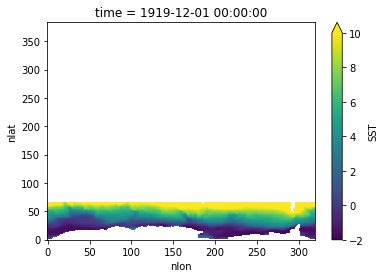

In [11]:
# Test: 
ds_so.SST.isel(time=0).plot(vmin=-2, vmax=10)


### Make regional masks:

In [12]:
#make masks on grid:
import pop_tools
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)

# Set it up:
lat = grid.TLAT
lon = grid.TLONG

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [13]:
# Mask out rectangles:
atl_mask = grid.TAREA.where((lat <= -45) & ((lon > 295) | (lon <= 55)) & (grid.REGION_MASK == 1)).fillna(0.) # ATLANTIC
ind_mask = grid.TAREA.where((lat <= -45) & ((lon > 55) & (lon <= 145)) & (grid.REGION_MASK == 1)).fillna(0.) # INDIAN
wpac_mask = grid.TAREA.where((lat <= -45) & ((lon > 145) & (lon <= 245)) & (grid.REGION_MASK == 1)).fillna(0.) # WEST PACIFIC
epac_mask = grid.TAREA.where((lat <= -45) & ((lon >= 245) & (lon <= 298)) & (grid.REGION_MASK == 1)).fillna(0.) # EAST PACIFIC

SO_mask = grid.TAREA.where((lat <= -45) & (grid.REGION_MASK == 1)).fillna(0.) #Southern Ocean

In [14]:
# Mask out rectangles but put them in an array
rmask = xr.DataArray(np.ones(5), dims='region') * grid.TAREA
rmask[0, :, :] = grid.TAREA.where((lat <= -45) & (grid.REGION_MASK == 1)).fillna(0.) #Southern Ocean
rmask[1, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 295) | (lon <= 55)) & (grid.REGION_MASK == 1)).fillna(0.) # ATLANTIC
rmask[2, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 55) & (lon <= 145)) & (grid.REGION_MASK == 1)).fillna(0.) # INDIAN
rmask[3, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 145) & (lon <= 245)) & (grid.REGION_MASK == 1)).fillna(0.) # WEST PACIFIC
rmask[4, :, :] = grid.TAREA.where((lat <= -45) & ((lon >= 245) & (lon <= 298)) & (grid.REGION_MASK == 1)).fillna(0.) # EAST PACIFIC

### Prep Data for Plotting:

In [16]:
#ds_sst_masked = ds_so.SST * rmask

In [18]:
#'''
from ncar_jobqueue import NCARCluster
#cluster = NCARCluster()
cluster = NCARCluster(project='UCUC0006')
cluster.scale(36) #adapt(minimum_jobs=1, maximum_jobs=40)
cluster
#''';

In [19]:
#'''
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client
#''';

Client Scheduler: tcp://128.117.181.208:44135 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [21]:
cluster.close()
client.close()

In [20]:
#Create 1-D Array of data:
# SST in SO (or region) monthly mean
sst_so_mean = (ds_so.SST * SO_mask).sum(['nlat', 'nlon']) / SO_mask.sum(['nlat', 'nlon'])
sst_so_mean = sst_so_mean.compute()

# Chl in SO (or region) monthly mean
chl_so_mean = (ds_so.Chl_surf * SO_mask).sum(['nlat', 'nlon']) / SO_mask.sum(['nlat', 'nlon'])
chl_so_mean = chl_so_mean.compute()

I keep getting this warning for really slow things: 
<blockquote>/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)</blockquote>

## Plot things
1. set up plotting

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import pop_tools
from statistics import mean
from matplotlib import style
from scipy import stats

In [24]:
#for saving figures:
pwd = os.getcwd()
os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/figures')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/figures'

In [25]:
style.use('ggplot')

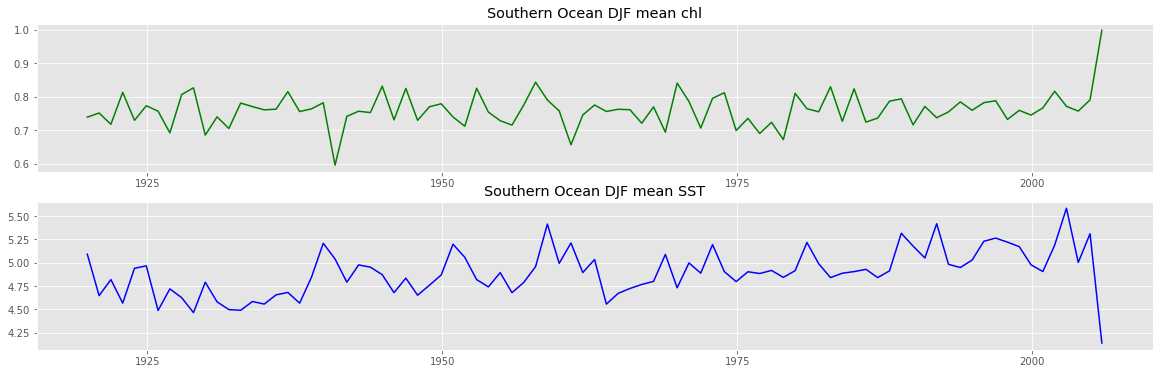

In [60]:
# Plot all Basins
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(211)
ax1.set_title('Southern Ocean DJF mean chl')
ax1.plot(chl_so_mean['time'].values, chl_so_mean.values, color = 'green')
plt.gca()

ax2 = fig.add_subplot(212)
ax2.set_title('Southern Ocean DJF mean SST')
ax2.plot(sst_so_mean['time'].values, sst_so_mean.values, color = 'blue')
plt.gca()

#plt.savefig('DJF-timeseries-SST-CHL-Mean.png')

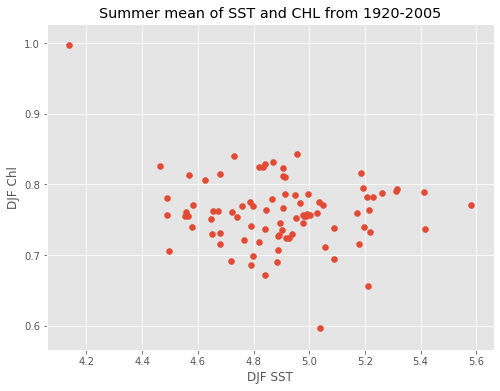

In [66]:
fig = plt.figure(figsize=(8,6))

plt.scatter(sst_so_mean.values, chl_so_mean.values)
plt.xlabel('DJF SST')
plt.ylabel('DJF Chl')
plt.title('Summer mean of SST and CHL from 1920-2005')
plt.gca()
plt.savefig('SSTxCHL-1920-2005.png')